<img src="news_img.png" alt="news-image" width=300>

## News Articles Classification
In the rapidly evolving landscape of digital media, where an overwhelming amount of news content is generated every minute, categorizing and making sense of this information has become a task of paramount importance. Natural Language Processing (NLP) is a field of AI and Machine Learning that focuses on understanding and interpreting human language in a valuable and meaningful way. We will employ NLP methods to categorize news articles based on their news category.

Dataset: https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning

Project by: George Tzimas

In [1]:
### Install packages

# !pip install wordcloud
# !pip install nltk
# !pip install svgling
# !pip install imblearn
# !pip install scipy
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from wordcloud import WordCloud
import re
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
import imblearn.over_sampling as os

In [3]:
df = pd.read_csv('CNN_Articels_clean.csv')
df.drop(columns=['Index'], inplace=True)
df.head()

Author       Date published  \
0                                 Jacopo Prisco, CNN  2021-07-15 02:46:59   
1                              Stephanie Bailey, CNN  2021-05-12 07:52:09   
2  Words by Stephanie Bailey, video by Zahra Jamshed  2021-06-16 02:51:30   
3                    Paul R. La Monica, CNN Business  2022-03-15 09:57:36   
4                                            Reuters  2022-03-15 11:27:02   

   Category    Section                                                Url  \
0      news      world  https://www.cnn.com/2021/07/14/world/tusimple-...   
1      news      world  https://www.cnn.com/2021/05/12/world/ironhand-...   
2      news       asia  https://www.cnn.com/2021/06/15/asia/swarm-robo...   
3  business  investing  https://www.cnn.com/2022/03/15/investing/brics...   
4  business   business  https://www.cnn.com/2022/03/15/business/russia...   

                                            Headline  \
0  There's a shortage of truckers, but TuSimple t...   
1  Bioservo's robotic 'Ironhand' could protect fa...   
2  This swarm of robots gets smarter the more it ...   
3  Russia is no longer an option for investors. T...   
4  Russian energy investment ban part of new EU s...   

                                         Description  \
0  The e-commerce boom has exacerbated a global t...   
1  Working in a factory can mean doing the same t...   
2  In a Hong Kong warehouse, a swarm of autonomou...   
3  For many years, the world's most popular emerg...   
4  The European Union formally approved on Tuesda...   

                                            Keywords  \
0  world, There's a shortage of truckers, but TuS...   
1  world, Bioservo's robotic 'Ironhand' could pro...   
2  asia, This swarm of robots gets smarter the mo...   
3  investing, Russia is no longer an option for i...   
4  business, Russian energy investment ban part o...   

                                     Second headline  \
0  There's a shortage of truckers, but TuSimple t...   
1  A robotic 'Ironhand' could protect factory wor...   
2  This swarm of robots gets smarter the more it ...   
3  Russia is no longer an option for investors. T...   
4  EU bans investment in Russian energy in new sa...   

                                        Article text  
0   (CNN)Right now, there's a shortage of truck d...  
1   (CNN)Working in a factory or warehouse can me...  
2   (CNN)In a Hong Kong warehouse, a swarm of aut...  
3  New York (CNN Business)For many years, the wor...  
4  The European Union formally approved on Tuesda...

#### Checking for missing values

In [4]:
df.isnull().sum()

Author             0
Date published     0
Category           0
Section            0
Url                0
Headline           0
Description        0
Keywords           0
Second headline    0
Article text       0
dtype: int64

There are no missing values in the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Author           4076 non-null   object
 1   Date published   4076 non-null   object
 2   Category         4076 non-null   object
 3   Section          4076 non-null   object
 4   Url              4076 non-null   object
 5   Headline         4076 non-null   object
 6   Description      4076 non-null   object
 7   Keywords         4076 non-null   object
 8   Second headline  4076 non-null   object
 9   Article text     4076 non-null   object
dtypes: object(10)
memory usage: 318.6+ KB


All of our features are object-type

#### Getting the year of each article

In [6]:
df['Date published'] = df['Date published'].astype('datetime64[ns]')
df['year'] = df['Date published'].dt.year
df.year.head()

0    2021
1    2021
2    2021
3    2022
4    2022
Name: year, dtype: int64

#### Cleaning the author feature

In [7]:
df.Author

0                                      Jacopo Prisco, CNN
1                                   Stephanie Bailey, CNN
2       Words by Stephanie Bailey, video by Zahra Jamshed
3                         Paul R. La Monica, CNN Business
4                                                 Reuters
                              ...                        
4071                                     Story by Reuters
4072                             Homero De la Fuente, CNN
4073                                    Amy Woodyatt, CNN
4074                                     Story by Reuters
4075                   Analysis by Stephen Collinson, CNN
Name: Author, Length: 4076, dtype: object

In [8]:
def get_author(text):
    text = text.strip().lower()
    
    # We will remove words that are not related to the author's name from each record
    remove_words = []
    remove_words.extend(df.Category.unique())
    remove_words.extend(df.Section.unique())
    remove_words.extend(['cnn', 'by', 'story', 'video', 'videos', 'analysis', 'words', 'for',
                         'opinion', 'produced', 'perspectives', 'photo', 'photos', 'illustration', 'illustrations', 'exclusive', 'graphics', 'staff'])
    remove_words = [word.lower() for word in remove_words]
    
    text_clean = ' '.join([word for word in text.split() if word not in remove_words])
    
    authors = re.split(',| and',text_clean)
    authors = [re.sub(r'[^a-z]', ' ', author) for author in authors]
    authors = [author for author in authors if len(author) > 1]
    # return ", ".join(authors)
    
    authors = [' '.join([i for i in author.split()]) for author in authors]
    authors = ', '.join([author for author in authors])
    
    if len(authors) != 0:
        return authors
    else:
        return np.nan

In [9]:
df['author_clean'] = df['Author'].apply(lambda x: get_author(x))

In [10]:
df['author_clean'].head(10)

0                      jacopo prisco
1                   stephanie bailey
2    stephanie bailey, zahra jamshed
3                   paul r la monica
4                            reuters
5                      paul p murphy
6                       oliver darcy
7                      charles riley
8                          matt egan
9                            reuters
Name: author_clean, dtype: object

Author features has been cleaned

In [11]:
df['author_clean'].isnull().sum()

17

In [12]:
df.dropna(inplace=True)

#### Cleaning the main article text

In [13]:
df['Article text'].head()

0     (CNN)Right now, there's a shortage of truck d...
1     (CNN)Working in a factory or warehouse can me...
2     (CNN)In a Hong Kong warehouse, a swarm of aut...
3    New York (CNN Business)For many years, the wor...
4    The European Union formally approved on Tuesda...
Name: Article text, dtype: object

The article text feature also contains additional information, such as "(CNN)" or "New York (CNN Business)". We will remove these types of text and keep the main article text.

In [14]:
def get_article_text(text):
    # clean_text = re.sub('\w*\s*\(\w+\s*\w*\)\s*', '', text.strip())
    # Regex that removes any starting text that contains the website in parentheses
    clean_text = re.sub('^[a-zA-Z ,]*\([a-zA-Z ]+\)', '', text.strip())
    return clean_text

In [15]:
df['text_clean'] = df['Article text'].apply(lambda x: get_article_text(x))

In [16]:
df['text_clean'].head()

0    Right now, there's a shortage of truck drivers...
1    Working in a factory or warehouse can mean doi...
2    In a Hong Kong warehouse, a swarm of autonomou...
3    For many years, the world's most popular emerg...
4    The European Union formally approved on Tuesda...
Name: text_clean, dtype: object

Articles have been cleaned.

#### Getting the article text length for each article

In [17]:
df['text_length'] = df['text_clean'].apply(lambda x: len(x))
df['text_length'].head()

0    12354
1     5809
2     3413
3     3276
4     3116
Name: text_length, dtype: int64

### Exploratory Data Analysis

#### Prediction Variable

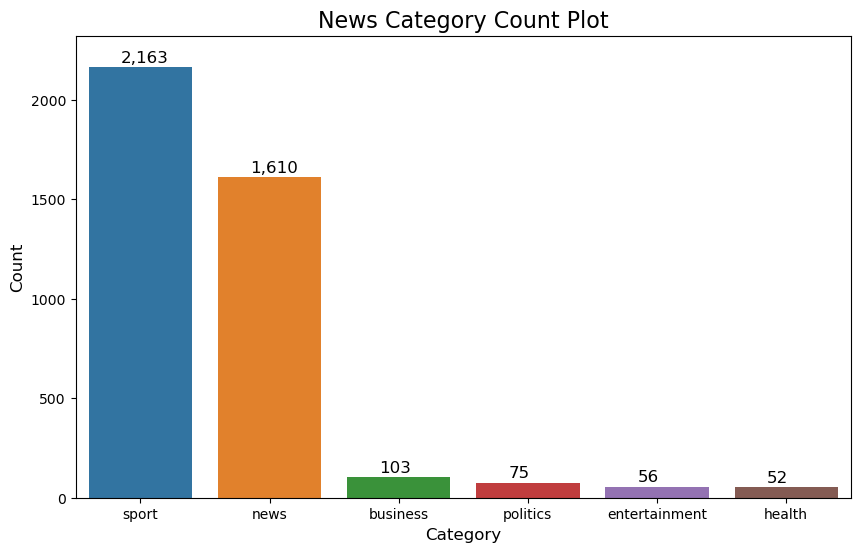

In [18]:
tmp = df.Category.value_counts()

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=tmp.index, y=tmp.values)
ax.set_title('News Category Count Plot', fontsize=16)
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
for i, vali in enumerate(tmp.values):
    ax.text(i-0.15, vali+25, format(vali, ','), fontdict={'fontsize':12})
ax.set_ylim(0, ax.get_ylim()[1]+50)
plt.show()

The majority of articles in this dataset fall either in the "sport" or "news" categories. This class imbalance will have to be adressed using an over-sampling technique during model training phase.

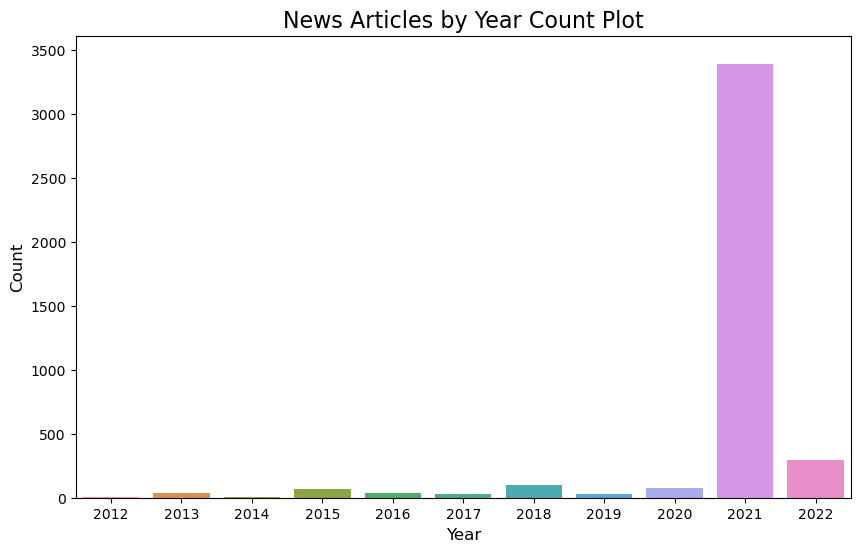

In [19]:
# tmp = df.year.value_counts()
tmp = df.year.value_counts().reset_index(name='count').sort_values(by='index', ascending=True)

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=tmp['index'], y=tmp['count'])
ax.set_title('News Articles by Year Count Plot', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
# for i, vali in zip(tmp.index, tmp.values):
#     ax.text(i, vali, format(vali, ','), fontdict={'fontsize':12})
ax.set_ylim(0, ax.get_ylim()[1]+50)
plt.show()

The vast majority of articles are from 2021.

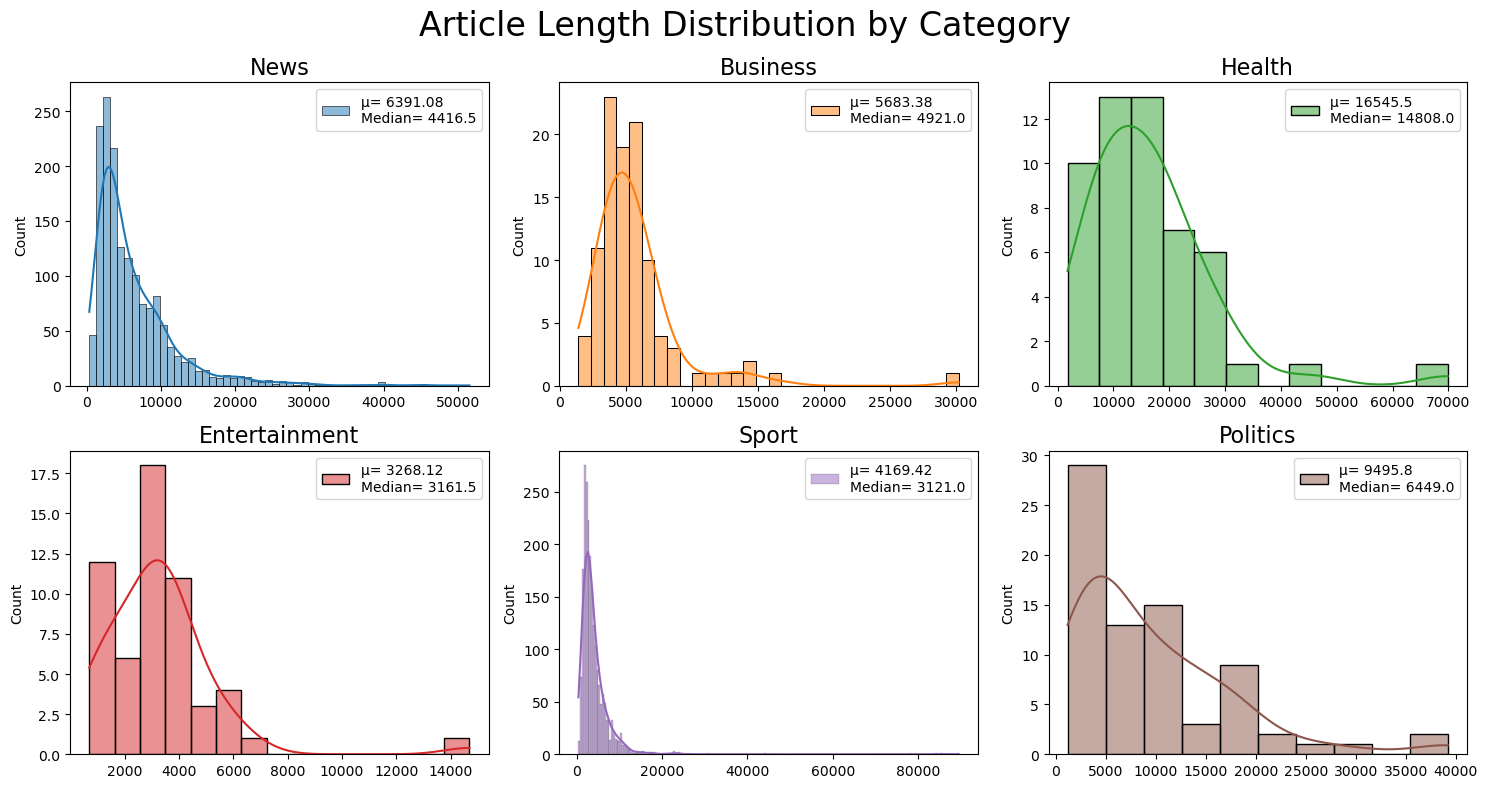

In [20]:
category_means = df.groupby('Category')['text_length'].mean()
category_values = list(df.Category.unique())
colors = sns.color_palette()[:6]
fig, ax = plt.subplots(2, 3, figsize=(15,8))
for axi, cati, coli in zip(ax.ravel(), category_values, colors):
    tmp = df[df.Category == cati]['text_length']
    mean = tmp.mean()
    median = tmp.median()
    sns.histplot(tmp, kde=True,  ax=axi, color=coli, label=f"μ= {np.round(mean, 2)}\nMedian= {np.round(median, 2)}")
    axi.set_title(cati.capitalize(), fontsize=16)
    axi.set_xlabel('')
    axi.legend()
    
fig.suptitle('Article Length Distribution by Category', fontsize=24)
fig.tight_layout()
plt.show()

• The article type with the largest mean article length is "health".

• The article type with the lowest mean article length is "entertainment". 

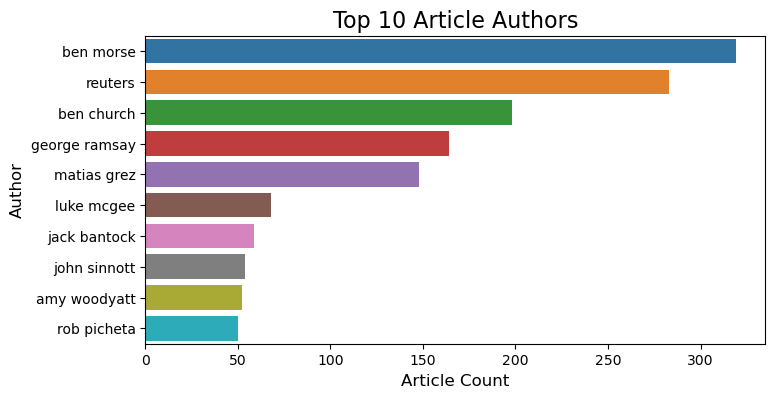

In [21]:
tmp = df['author_clean'].value_counts()[:10]
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(y=tmp.index, x=tmp.values)
ax.set_title('Top 10 Article Authors', fontsize=16)
ax.set_xlabel('Article Count', fontsize=12)
ax.set_ylabel('Author', fontsize=12)
plt.show()

### Preprocessing the article text

In [22]:
# Use this pattern to separate the text words
tokenizer = nltk.RegexpTokenizer('[^a-zA-Z0-9-\']', gaps=True)
# Remove stopwords such as "the", "it", "they" from the text that does not provide any value
stopwords = nltk.corpus.stopwords.words('english')
# Perform stemming on each word, reducing them to their base/root form, e.g. "stepped" -> "step"
stemmer = nltk.stem.PorterStemmer()
df['tokens'] = df['text_clean'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['tokens_combined'] = df.tokens.apply(lambda x: ' '.join([word for word in x]))
df['no_stopwords'] = df.tokens.apply(lambda x: ' '.join([word for word in x if word not in stopwords]))
df['stemmed'] = df.tokens.apply(lambda x: ' '.join([stemmer.stem(word) for word in x if word not in stopwords]))
# Add part-of-speech tagging for each word, categorizing it as a noun, verb, etc.
df['pos_tags'] = df.tokens.apply(lambda x: nltk.pos_tag(x))

In [23]:
df[['tokens', 'tokens_combined', 'no_stopwords', 'stemmed', 'pos_tags']].head()

tokens  \
0  [right, now, there's, a, shortage, of, truck, ...   
1  [working, in, a, factory, or, warehouse, can, ...   
2  [in, a, hong, kong, warehouse, a, swarm, of, a...   
3  [for, many, years, the, world's, most, popular...   
4  [the, european, union, formally, approved, on,...   

                                     tokens_combined  \
0  right now there's a shortage of truck drivers ...   
1  working in a factory or warehouse can mean doi...   
2  in a hong kong warehouse a swarm of autonomous...   
3  for many years the world's most popular emergi...   
4  the european union formally approved on tuesda...   

                                        no_stopwords  \
0  right there's shortage truck drivers us worldw...   
1  working factory warehouse mean task repetition...   
2  hong kong warehouse swarm autonomous robots wo...   
3  many years world's popular emerging markets so...   
4  european union formally approved tuesday new b...   

                                             stemmed  \
0  right there' shortag truck driver us worldwid ...   
1  work factori warehous mean task repetit lead c...   
2  hong kong warehous swarm autonom robot work 24...   
3  mani year world' popular emerg market so-cal b...   
4  european union formal approv tuesday new barra...   

                                            pos_tags  
0  [(right, RB), (now, RB), (there's, VBZ), (a, D...  
1  [(working, VBG), (in, IN), (a, DT), (factory, ...  
2  [(in, IN), (a, DT), (hong, NN), (kong, NN), (w...  
3  [(for, IN), (many, JJ), (years, NNS), (the, DT...  
4  [(the, DT), (european, JJ), (union, NN), (form...

In [24]:
def chunk_wordcloud(df, pos_column, chunk_grammar, groupby_col=None, image_title='Noun Phrases', font_size=40, font_weight='normal', figure_size=(20,8), title_y_pos=1.05, tight_layout=True,\
 wc_width=1600, wc_height=800, wc_max_words=200, interpolation='bilinear'):
    
    if groupby_col != None:
        frequencies = dict()
        unique_values = list(df[groupby_col].unique())
        for value in unique_values:
            frequencies[value] = nltk.probability.FreqDist()
    else:
        frequencies = nltk.probability.FreqDist()
        
    parser = nltk.RegexpParser(chunk_grammar)
    for i, pos_tags in enumerate(df[pos_column]):
        parsed_text = parser.parse(pos_tags)
        for text in parsed_text:
            if hasattr(text, 'label'):
                result = ' '.join([word for word, tag in text])
                if type(frequencies) == dict:
                    frequencies[df.iloc[i][groupby_col]][result] += 1
                elif type(frequencies) == nltk.probability.FreqDist:
                    frequencies[result] += 1
    
    if type(frequencies) == dict:
        figures = dict()
        for freq in frequencies.keys():
            wordcloud = WordCloud(width=wc_width, height=wc_height, max_words=wc_max_words).generate_from_frequencies(frequencies[freq])
            fig, ax = plt.subplots(figsize=figure_size)
            fig.set_facecolor('black')
            ax.imshow(wordcloud, interpolation=interpolation)
            ax.set_axis_off()
            ax.set_title(f"{freq.capitalize()} {image_title}", fontsize=font_size, fontweight=font_weight, color='white', y=title_y_pos)
            if tight_layout == True:
                fig.tight_layout()
            plt.close()
            figures[freq] = fig
        return figures
    elif type(frequencies) == nltk.probability.FreqDist:
        wordcloud = WordCloud(width=wc_width, height=wc_height, max_words=wc_max_words).generate_from_frequencies(frequencies)
        fig, ax = plt.subplots(figsize=figure_size)
        fig.set_facecolor('black')
        ax.imshow(wordcloud, interpolation=interpolation)
        ax.set_axis_off()
        ax.set_title(image_title, fontsize=font_size, fontweight=font_weight, color='white', y=title_y_pos)
        if tight_layout == True:
            fig.tight_layout()
        plt.close()
        return fig

In [25]:
np_figures = chunk_wordcloud(df, 'pos_tags', "NP: {<DT.?><JJ.?>?<NN.?>}", 'Category', figure_size=(15,10), font_weight='bold') 

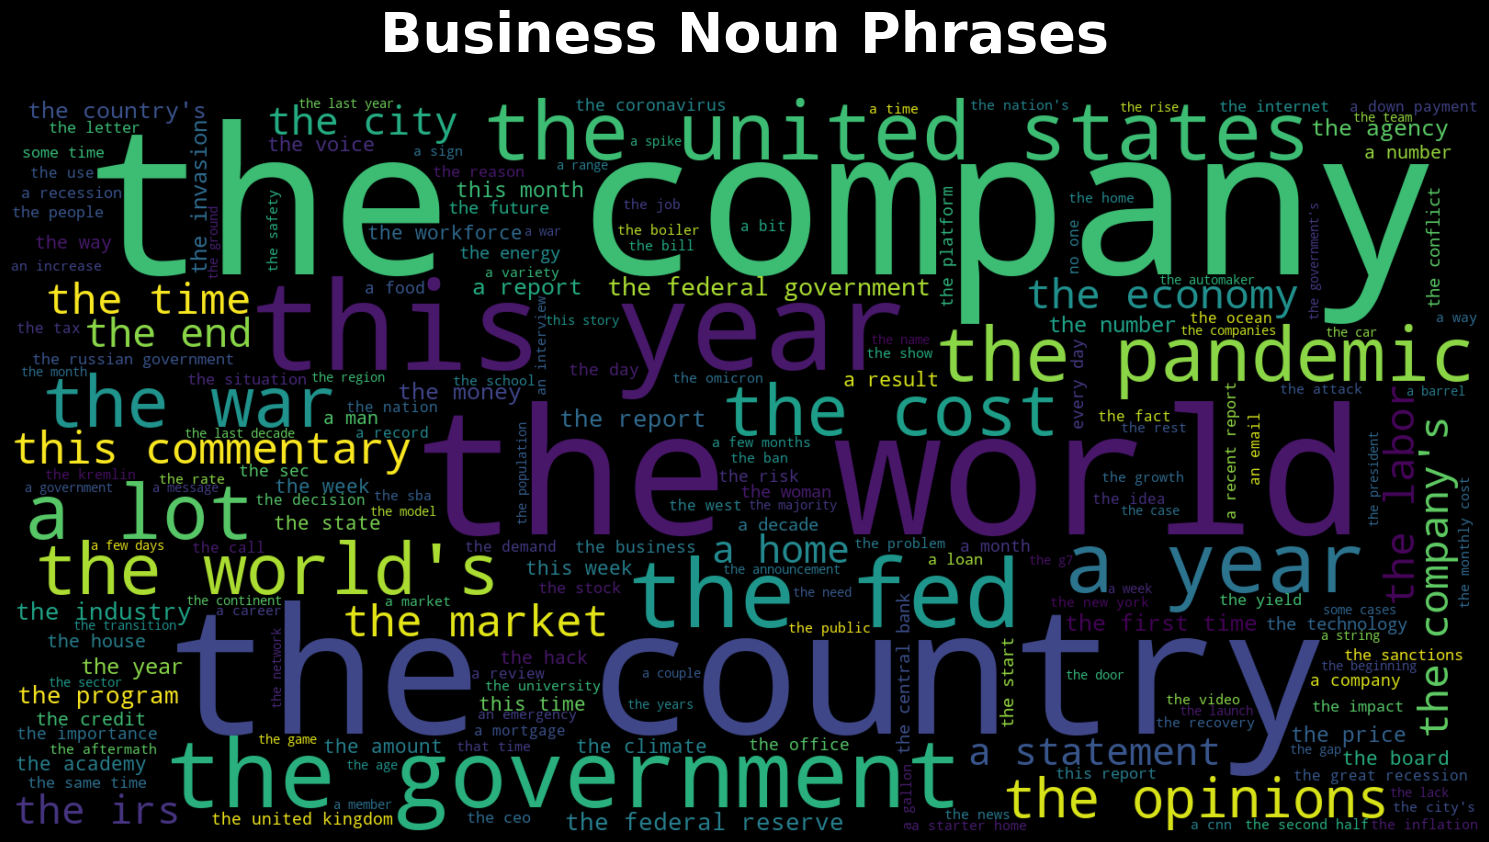

In [26]:
np_figures['business']

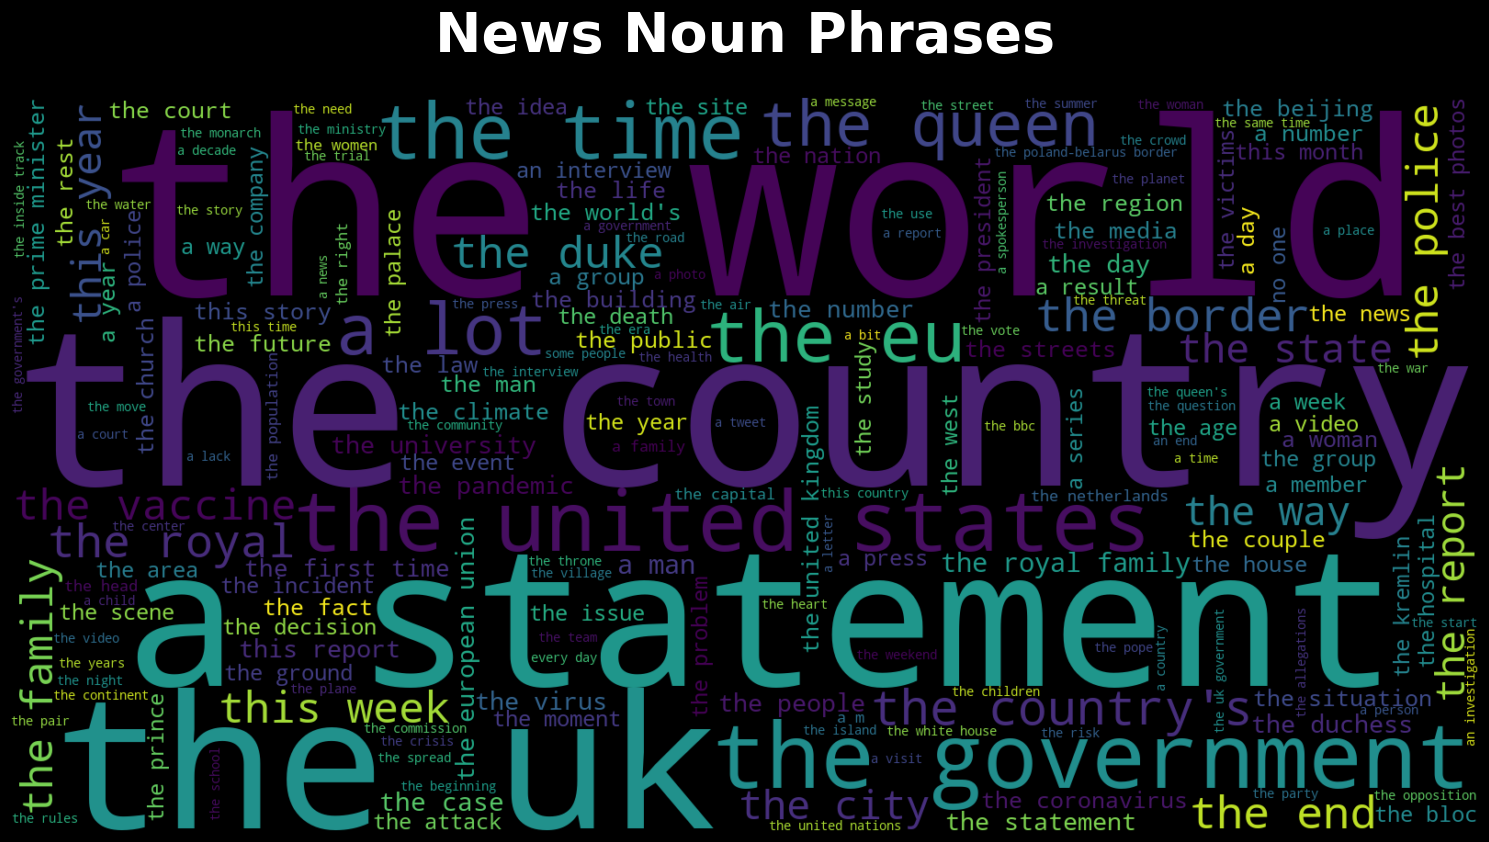

In [27]:
np_figures['news']

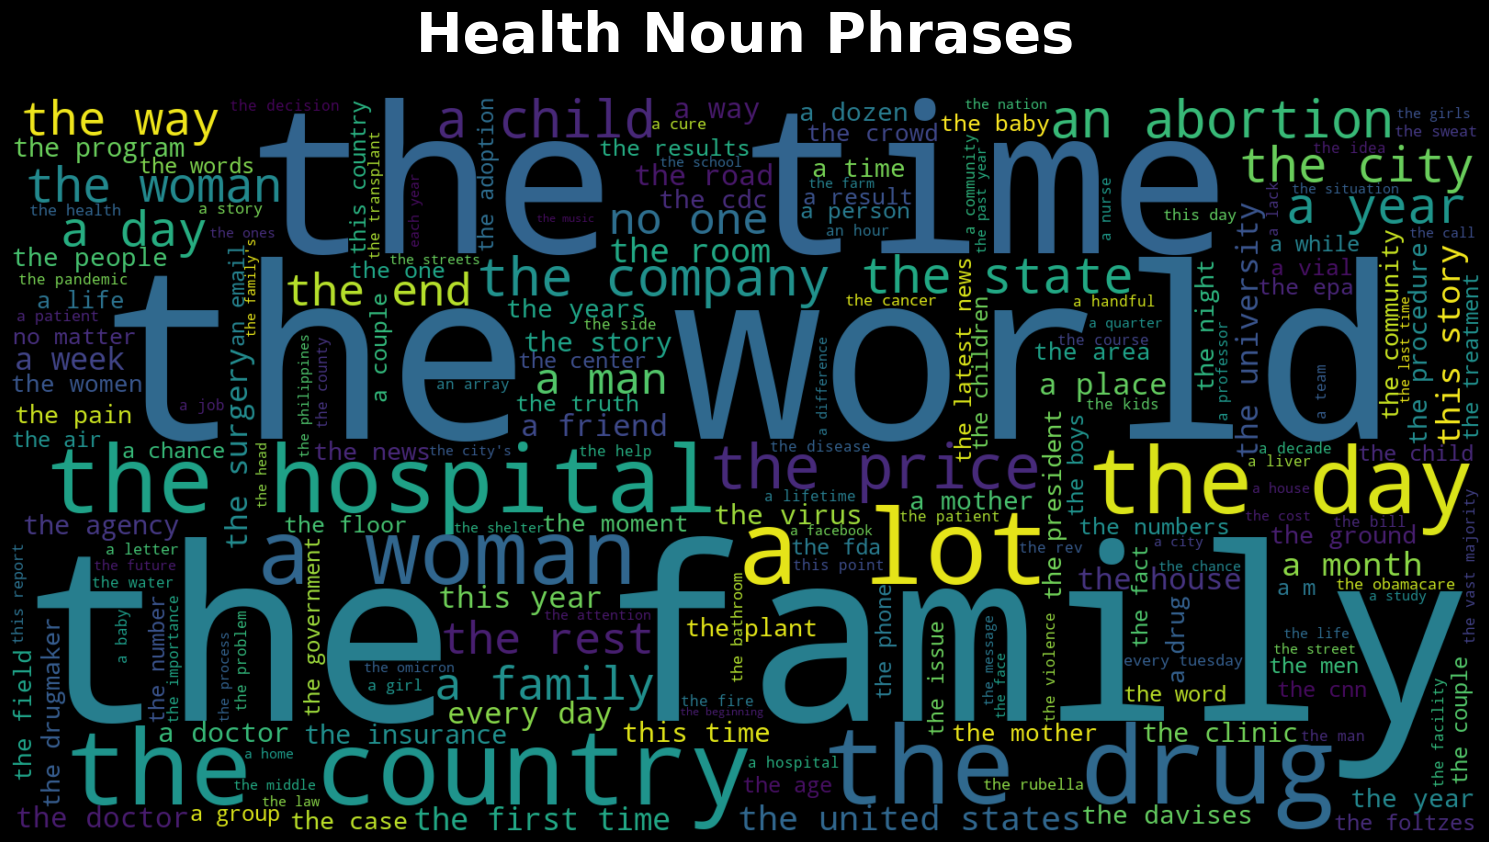

In [28]:
np_figures['health']

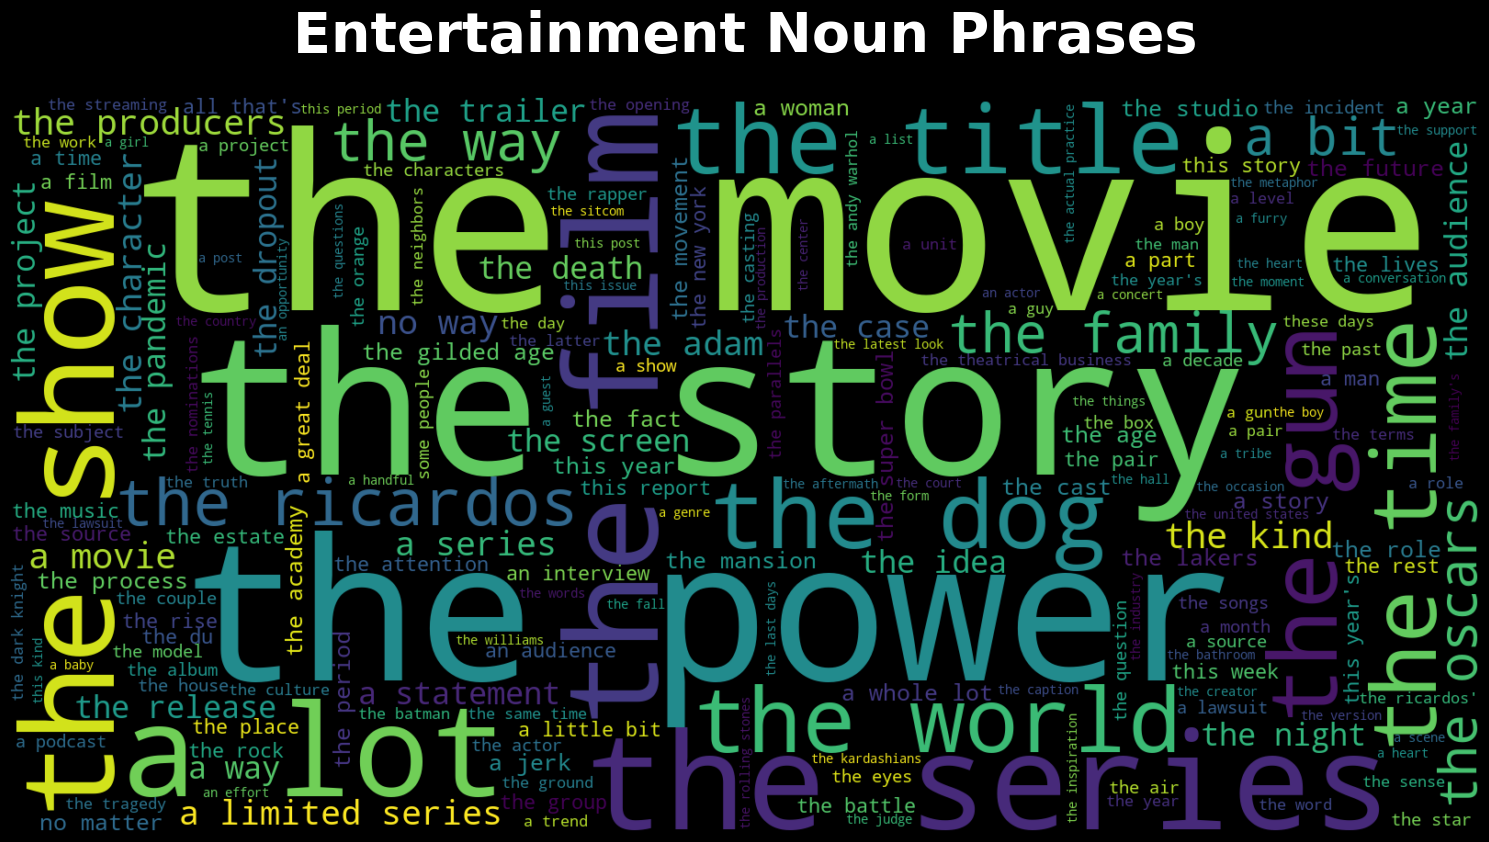

In [29]:
np_figures['entertainment']

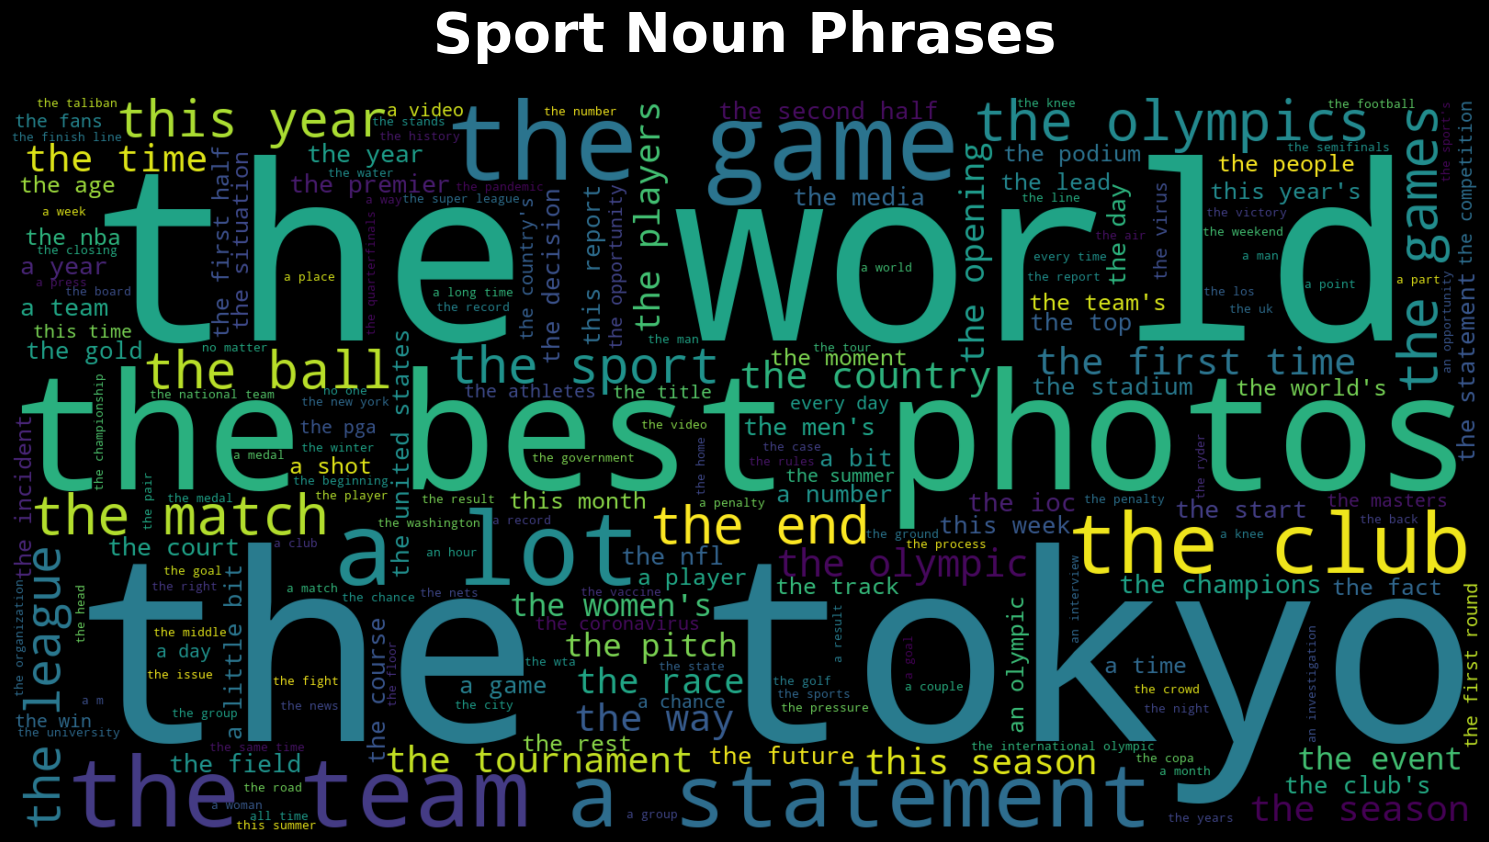

In [30]:
np_figures['sport']

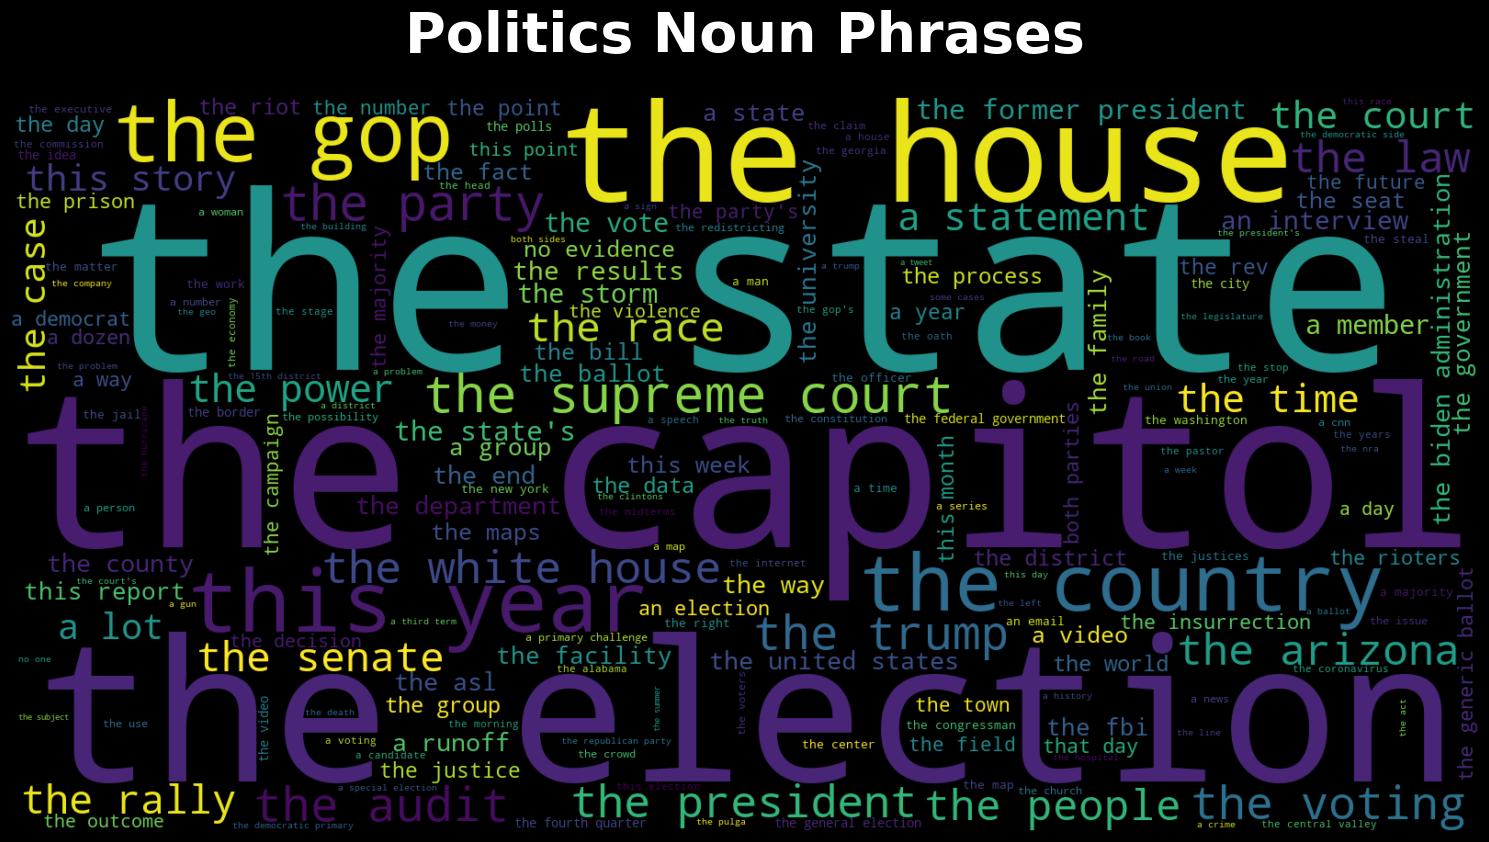

In [31]:
np_figures['politics']

### Label-encoding the prediction feature

In [32]:
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df.Category)
le_classes = list(label_encoder.classes_)
df['encoded_labels'].head()

0    3
1    3
2    3
3    0
4    0
Name: encoded_labels, dtype: int64

### Splitting the data into train/test/validation sets

In [33]:
X = df['stemmed']
y = df['encoded_labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=1)

In [34]:
print(f"{'='*20}\nX_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}\n{'='*20}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

X_train: (2435,)
X_test: (812,)
y_train: (2435,)
y_test: (812,)
X_val: (812,)
y_val: (812,)


### Calculating word/term frequencies for each article

In [35]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df=1., max_features=500, lowercase=False)
X_train_cv = tfidf.fit_transform(X_train).toarray()
X_test_cv = tfidf.transform(X_test).toarray()
X_val_cv = tfidf.transform(X_val).toarray()

### Fixing class imbalance for the dependent variable

In [36]:
smote = os.SMOTE(random_state=1)
X_train_os, y_train_os = smote.fit_resample(X_train_cv, y_train)

In [37]:
pd.concat([y_train.value_counts().rename('Before'), y_train_os.value_counts().rename('After')], axis=1)

Before  After
5    1298   1298
3     965   1298
0      62   1298
4      41   1298
1      36   1298
2      33   1298

### Model 1: Random Forest Classifier

In [38]:
rfc = RandomForestClassifier()
rfc.fit(X_train_os, y_train_os)
rfc_pred_train = rfc.predict(X_train_os)
rfc_pred_test = rfc.predict(X_test_cv)
rfc_pred_val = rfc.predict(X_val_cv)

In [39]:
print(metrics.classification_report(y_train_os, y_train_os))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1298
           1       1.00      1.00      1.00      1298
           2       1.00      1.00      1.00      1298
           3       1.00      1.00      1.00      1298
           4       1.00      1.00      1.00      1298
           5       1.00      1.00      1.00      1298

    accuracy                           1.00      7788
   macro avg       1.00      1.00      1.00      7788
weighted avg       1.00      1.00      1.00      7788



In [40]:
print(metrics.classification_report(y_test, rfc_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.24      0.38        17
           1       1.00      0.23      0.38        13
           2       0.50      0.29      0.36        14
           3       0.86      0.96      0.91       325
           4       1.00      0.13      0.24        15
           5       0.96      0.97      0.97       428

    accuracy                           0.91       812
   macro avg       0.89      0.47      0.54       812
weighted avg       0.92      0.91      0.90       812



In [41]:
print(metrics.classification_report(y_val, rfc_pred_val))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        24
           1       1.00      0.29      0.44         7
           2       0.00      0.00      0.00         5
           3       0.88      0.97      0.93       320
           4       1.00      0.37      0.54        19
           5       0.97      0.99      0.98       437

    accuracy                           0.93       812
   macro avg       0.81      0.46      0.53       812
weighted avg       0.93      0.93      0.92       812



The Random Forest model has high recall values for categories 3 and 5, but relatively low scores for all other categories compared to its performance on the training set.

This suggests the model might be overfitting the training data.

In [42]:
def display_cm(cm, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues', fmt='d')
    ax.set_xlabel('Actual', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)
    ax.set_title(title, fontsize=16)
    plt.show()

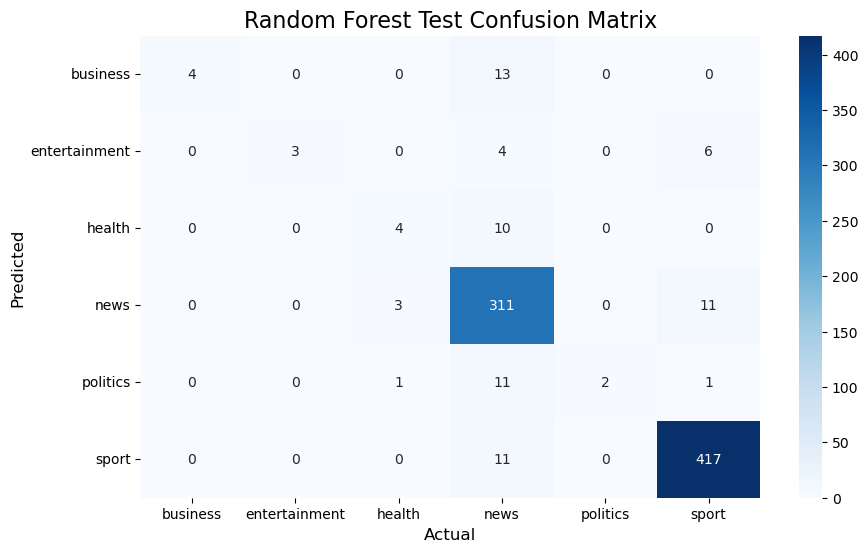

In [43]:
display_cm(metrics.confusion_matrix(y_test, rfc_pred_test), 'Random Forest Test Confusion Matrix')

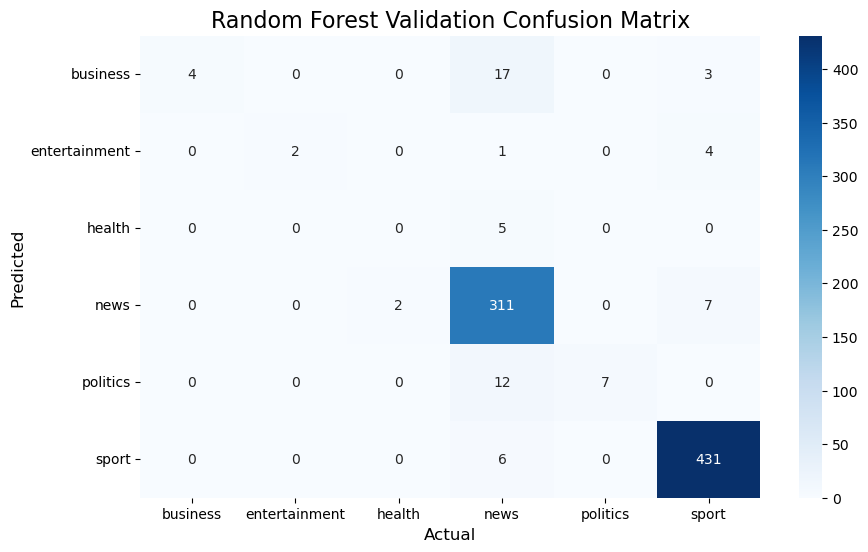

In [44]:
display_cm(metrics.confusion_matrix(y_val, rfc_pred_val), 'Random Forest Validation Confusion Matrix')

### Model 2: Multinomial Naive Bayes Classifier

In [45]:
mnb = MultinomialNB()
mnb.fit(X_train_os, y_train_os)
mnb_pred_train = mnb.predict(X_train_os)
mnb_pred_test = mnb.predict(X_test_cv)
mnb_pred_val = mnb.predict(X_val_cv)

In [46]:
print(metrics.classification_report(y_train_os, mnb_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1298
           1       0.97      0.98      0.98      1298
           2       0.87      0.97      0.92      1298
           3       0.91      0.80      0.86      1298
           4       0.96      0.99      0.97      1298
           5       0.97      0.95      0.96      1298

    accuracy                           0.94      7788
   macro avg       0.94      0.94      0.94      7788
weighted avg       0.94      0.94      0.94      7788



In [47]:
print(metrics.classification_report(y_test, mnb_pred_test))

              precision    recall  f1-score   support

           0       0.40      0.82      0.54        17
           1       0.90      0.69      0.78        13
           2       0.22      0.93      0.35        14
           3       0.92      0.78      0.84       325
           4       0.48      0.73      0.58        15
           5       0.99      0.94      0.97       428

    accuracy                           0.87       812
   macro avg       0.65      0.82      0.68       812
weighted avg       0.92      0.87      0.89       812



In [48]:
print(metrics.classification_report(y_val, mnb_pred_val))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57        24
           1       0.64      1.00      0.78         7
           2       0.05      0.40      0.09         5
           3       0.93      0.81      0.87       320
           4       0.59      0.89      0.71        19
           5       0.99      0.95      0.96       437

    accuracy                           0.88       812
   macro avg       0.61      0.79      0.66       812
weighted avg       0.93      0.88      0.90       812



Multinomial Naive Bayes has better recall metrics on both testing and validation sets compared to Random Forest.

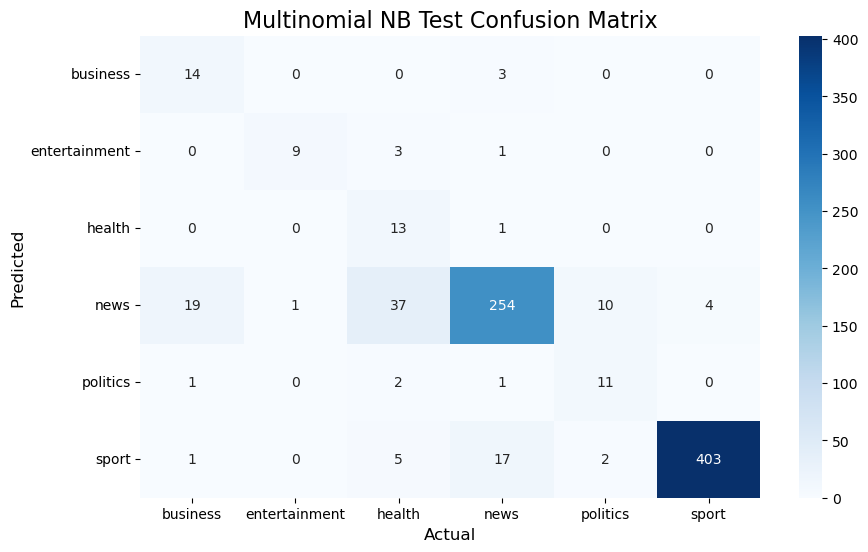

In [49]:
display_cm(metrics.confusion_matrix(y_test, mnb_pred_test), 'Multinomial NB Test Confusion Matrix')

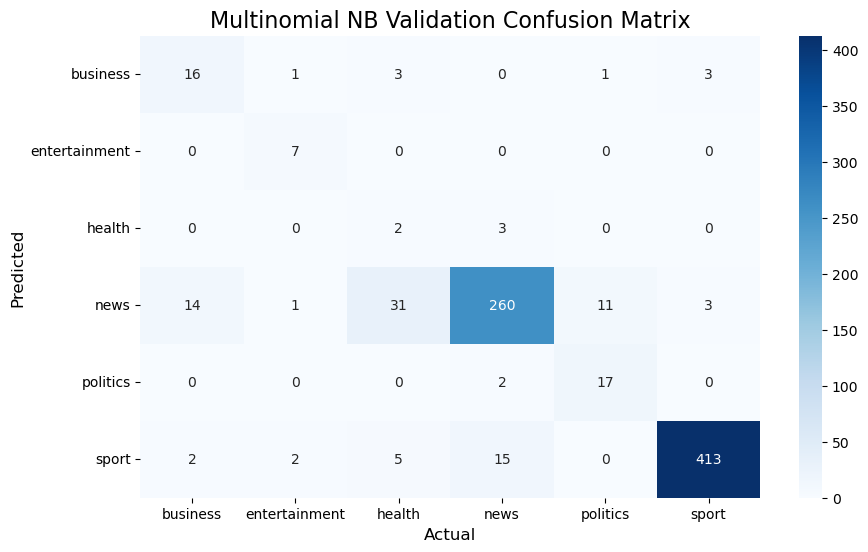

In [50]:
display_cm(metrics.confusion_matrix(y_val, mnb_pred_val), 'Multinomial NB Validation Confusion Matrix')

### Model 3: Support Vector Classifier

In [51]:
svc = SVC()
svc.fit(X_train_os, y_train_os)
svc_pred_train = svc.predict(X_train_os)
svc_pred_test = svc.predict(X_test_cv)
svc_pred_val = svc.predict(X_val_cv)

In [52]:
print(metrics.classification_report(y_train_os, svc_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1298
           1       1.00      1.00      1.00      1298
           2       1.00      1.00      1.00      1298
           3       1.00      0.99      1.00      1298
           4       1.00      1.00      1.00      1298
           5       0.99      1.00      1.00      1298

    accuracy                           1.00      7788
   macro avg       1.00      1.00      1.00      7788
weighted avg       1.00      1.00      1.00      7788



In [53]:
print(metrics.classification_report(y_test, svc_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       1.00      0.15      0.27        13
           2       1.00      0.36      0.53        14
           3       0.87      0.98      0.92       325
           4       0.82      0.60      0.69        15
           5       0.99      0.96      0.98       428

    accuracy                           0.93       812
   macro avg       0.93      0.61      0.68       812
weighted avg       0.94      0.93      0.93       812



In [54]:
print(metrics.classification_report(y_val, svc_pred_val))

              precision    recall  f1-score   support

           0       1.00      0.46      0.63        24
           1       1.00      0.43      0.60         7
           2       1.00      0.20      0.33         5
           3       0.88      0.97      0.93       320
           4       0.85      0.58      0.69        19
           5       0.98      0.96      0.97       437

    accuracy                           0.93       812
   macro avg       0.95      0.60      0.69       812
weighted avg       0.94      0.93      0.93       812



Support Vector Classifier is also performing better than Random Forest on the recall metric, but underperforming compared to the Multinomial Naive Bayes model.

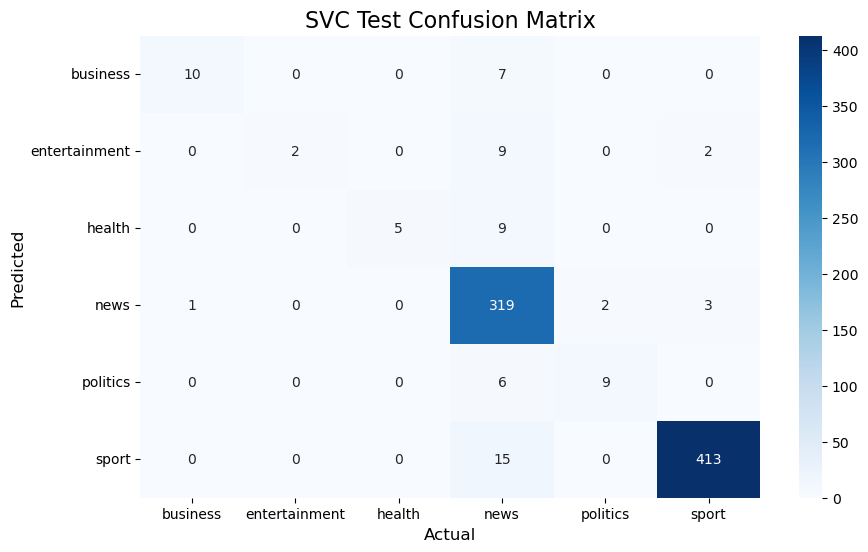

In [55]:
display_cm(metrics.confusion_matrix(y_test, svc_pred_test), 'SVC Test Confusion Matrix')

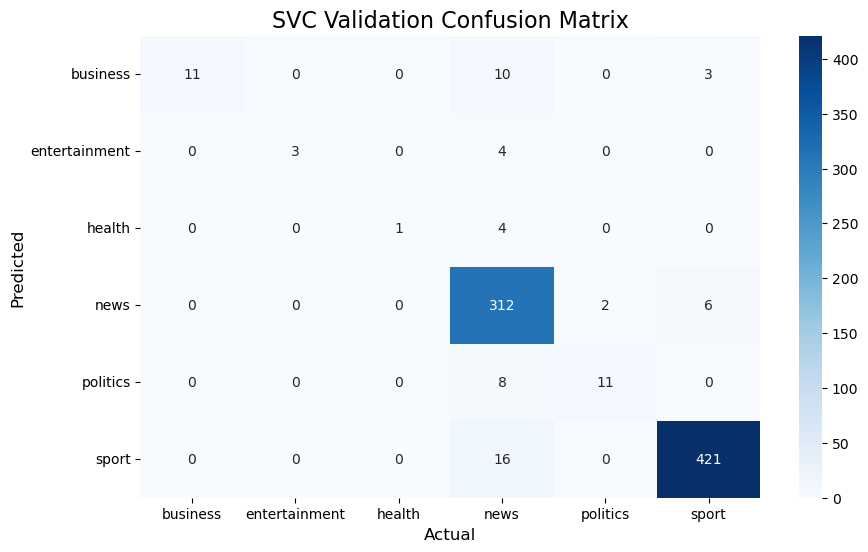

In [56]:
display_cm(metrics.confusion_matrix(y_val, svc_pred_val), 'SVC Validation Confusion Matrix')

In [57]:
pd.DataFrame(metrics.classification_report(y_test, rfc_pred_test, output_dict=True)).T

precision    recall  f1-score     support
0              1.000000  0.235294  0.380952   17.000000
1              1.000000  0.230769  0.375000   13.000000
2              0.500000  0.285714  0.363636   14.000000
3              0.863889  0.956923  0.908029  325.000000
4              1.000000  0.133333  0.235294   15.000000
5              0.958621  0.974299  0.966396  428.000000
accuracy       0.912562  0.912562  0.912562    0.912562
macro avg      0.887085  0.469389  0.538218  812.000000
weighted avg   0.915091  0.912562  0.897412  812.000000

In [58]:
pd.DataFrame(metrics.classification_report(y_test, mnb_pred_test, output_dict=True)).T

precision    recall  f1-score     support
0              0.400000  0.823529  0.538462   17.000000
1              0.900000  0.692308  0.782609   13.000000
2              0.216667  0.928571  0.351351   14.000000
3              0.916968  0.781538  0.843854  325.000000
4              0.478261  0.733333  0.578947   15.000000
5              0.990172  0.941589  0.965269  428.000000
accuracy       0.866995  0.866995  0.866995    0.866995
macro avg      0.650345  0.816812  0.676749  812.000000
weighted avg   0.924280  0.866995  0.887092  812.000000

In [59]:
pd.DataFrame(metrics.classification_report(y_val, svc_pred_test, output_dict=True)).T

precision    recall  f1-score     support
0              0.000000  0.000000  0.000000   24.000000
1              0.000000  0.000000  0.000000    7.000000
2              0.000000  0.000000  0.000000    5.000000
3              0.421918  0.481250  0.449635  320.000000
4              0.000000  0.000000  0.000000   19.000000
5              0.559809  0.535469  0.547368  437.000000
accuracy       0.477833  0.477833  0.477833    0.477833
macro avg      0.163621  0.169453  0.166167  812.000000
weighted avg   0.467549  0.477833  0.471777  812.000000

Out of the three models, Multinomial Naives Bayes seems to be the most promising model for categorizing news articles.

Some further steps from this point would be using GridSearchCV in order to find the optimum hyperparameters for model performance. 

In addition, oversampling might've not been as effective in this case due to the relatively low proportion of articles that fell on the categories not including "sports" or "news", therefore making sampling with replacement less ideal.